
<a id='statd'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Cadeias de Markov de Estado Contínuo


<a id='index-1'></a>

## Conteúdo

- [Cadeias de Markov de Estado Contínuo](#Cadeias-de-Markov-de-Estado-Contínuo)  
  - [Resumo](#Resumo)  
  - [O Caso da Densidade](#O-Caso-da-Densidade)  
  - [Além das Densidades](#Além-das-Densidades)  
  - [Estabilidade](#Estabilidade)  
  - [Exercícios](#Exercícios)  
  - [Soluções](#Soluções)  
  - [Apêndice](#Apêndice)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Em uma [aula anterior](https://julia.quantecon.org/finite_markov.html) aprendemos sobre as cadeias finitas de Markov, uma classe relativamente elementar de modelos estocásticos dinâmicos.

A presente aula extende essa análise para cadeias de Markov de estado contínuo (ou seja, incontáveis) 

A maioria dos modelos dinâmicos estocásticos estudados por economistas se encaixa diretamente nessa classe ou pode ser representada como cadeias de Markov de estado contínuo após pequenas modificações.

Nesta aula, nosso foco estará nos modelos Markov contínuos que

- evoluem em tempo discreto
- são geralmente não lineares  


O fato de acomodarmos modelos não lineares aqui é significativo, porque os modelos estocásticos lineares têm seu próprio conjunto de ferramentas altamente desenvolvido, como veremos [mais adiante](https://julia.quantecon.org/../time_series_models/arma.html).

A questão que mais nos interessa é: Dado um modelo dinâmico estocástico específico, como o estado do sistema evoluirá com o tempo?

Em particular,

- O que acontece com a distribuição das variáveis de estado?  
- Existe algo que possamos dizer sobre o "comportamento médio" dessas variáveis?  
- Existe uma noção de "estado estacionário" ou "equilíbrio de longo prazo" aplicável ao modelo?  
  
  - se sim, como podemos calcular ele?  
  


Respondendo essas questões nos levará a revisitar muitos dos tópicos que nos ocupavam no caso de estado finito, como simulação, dinâmica de distribuição, estabilidade, ergodicidade etc.

>**Nota**
>
>Para algumas pessoas, o termo “cadeia de Markov” sempre refere-se a um processo com estado de espaço finito ou discreto.  Seguimos a literatura matemática convencional (por exemplo, [[MT09]](https://julia.quantecon.org/../zreferences.html#meyntweedie2009)) usando o termo para se referir a qualquer processo de Markov discreto no **tempo** 

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics
using KernelDensity, Distributions, Plots, QuantEcon, Random


<a id='statd-density-case'></a>

## O Caso da Densidade

Você provavelmente está ciente de que algumas distribuições podem ser representadas por densidades e outras não.

(Por exemplo, distribuições em números reais $ \mathbb R $ que colocam probabilidade positiva em pontos individuais não têm representação de densidade)

Começaremos nossa análise observando as cadeias de Markov, onde as probabilidades de transição em uma etapa têm representações de densidade.

O benefício é que o caso de densidade oferece um paralelo muito direto ao caso finito em termos de notação e intuição.

Depois de criar alguma intuição, abordaremos o caso geral.

### Definições e Propriedades Básicas

Em nossa [aula sobre cadeias finitas de Markov](https://julia.quantecon.org/finite_markov.html), estudamos cadeias de Markov de tempo discreto que evoluem em um finito espaço estado $ S $.

Nesse cenário, a dinâmica do modelo é descrita por uma matriz estocástica - uma matriz quadrada não-negativa $ P = P[i, j] $ de tal modo que cada linha $ P[i, \cdot] $ some a um.

A interpretação de $ P $ é que $ P[i, j] $ representa a probabilidade de transição do estado $ i $ para o estado $ j $ em uma unidade de tempo.

Em símbolos,

$$
\mathbb P \{ X_{t+1} = j \,|\, X_t = i \} = P[i, j]
$$

Equivalentemente,

- $ P $ pode ser pensado como uma família de distribuições $ P[i, \cdot] $, uma para cada $ i \in S $  
- $ P[i, \cdot] $ é a distribuição de $ X_{t+1} $ dado $ X_t = i $  


(Como você provavelmente se lembra, ao usar matrizes Julia, $ P[i, \cdot] $ é expresso como `P[i,:]`)

Nessa seção, permitiremos $ S $ ser um subconjunto de $ \mathbb R $, tal como

- $ \mathbb R $   
- os números reais positivos $ (0, \infty) $  
- um intervalo limitado $ (a, b) $  


A família de distribuiçoes discretas $ P[i, \cdot] $ será substituido por uma família de densidades $ p(x, \cdot) $, uma para cada $ x \in S $.

Análogo ao caso de estado finito, $ p(x, \cdot) $ deve ser entendido como uma distribuição (densidade) de $ X_{t+1} $ dado $ X_t = x $.

Mais formalmente, um *núcleo estocástico em* $ S $ é uma função $ p \colon S \times S \to \mathbb R $ com a propriedade que

1. $ p(x, y) \geq 0 $ para todo $ x, y \in S $  
1. $ \int p(x, y) dy = 1 $ para todo $ x \in S $  


(as integrais estão em todo o espaço, a menos que especificadas de outra forma)

Por exemplo, faça $ S = \mathbb R $ e considere o particular núcleo estocástico $ p_w $ definido por


<a id='equation-statd-rwsk'></a>
$$
p_w(x, y) := \frac{1}{\sqrt{2 \pi}} \exp \left\{ - \frac{(y - x)^2}{2} \right\} \tag{1}
$$

Que tipo de modelo $ p_w $ representa?

A resposta é o passeio aleatório (normalmente distribuído):

<a id='equation-statd-rw'></a>
$$
X_{t+1} = X_t + \xi_{t+1}
\quad \text{onde} \quad
\{ \xi_t \} \stackrel {\textrm{ IID }} {\sim} N(0, 1) \tag{2}
$$

Para ver isso, vamos encontrar o núcleo estocástico $ p $ correspondente a [(2)](#equation-statd-rw).

Lembre-se que $ p(x, \cdot) $ representa a distribuição de $ X_{t+1} $ dado $ X_t = x $.

Fazendo $ X_t = x $ em [(2)](#equation-statd-rw) e considerando a distribuição $ X_{t+1} $, podemos ver que $ p(x, \cdot) = N(x, 1) $.

Em outras palavras, $ p $ é exatamente $ p_w $, como definido em [(1)](#equation-statd-rwsk).

### Conexão com Equações de Diferença Estocástica

Na seção anterior, fizemos a conexão entre a equação da diferença estocástica [(2)](#equation-statd-rw) e o núcleo estocástico [(1)](#equation-statd-rwsk).

Na análise econômica e de séries temporais, encontramos equações de diferença estocástica de todas as formas e tamanhos diferentes.

Será útil para nós se tivermos alguns métodos sistemáticos para converter equações de diferença estocástica em núcleos estocásticos.

Para esse fim, considere a equação genérica (escalar) da diferença estocástica  dada por


<a id='equation-statd-srs'></a>
$$
X_{t+1} = \mu(X_t) + \sigma(X_t) \, \xi_{t+1} \tag{3}
$$

Aqui assumimos que

- $ \{ \xi_t \} \stackrel {\textrm{ IID }} {\sim} \phi $, onde $ \phi $ é uma dada densidade em $ \mathbb R $  
- $ \mu $ e $ \sigma $ são dadas funções em $ S $, com $ \sigma(x) > 0 $ para todo $ x $  


**Exemplo 1:** O passeio aleatório [(2)](#equation-statd-rw) é um caso especial de [(3)](#equation-statd-srs), com $ \mu(x) = x $ e $ \sigma(x) = 1 $.

**Exemplo 2:** Considere o [modelo ARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity)

$$
X_{t+1} = \alpha X_t + \sigma_t \,  \xi_{t+1},
\qquad \sigma^2_t = \beta + \gamma X_t^2,
\qquad \beta, \gamma > 0
$$

Alternativamente, podemos escrever esse modelo como


<a id='equation-statd-arch'></a>
$$
X_{t+1} = \alpha X_t + (\beta + \gamma X_t^2)^{1/2} \xi_{t+1} \tag{4}
$$

Esse é um caso especial de [(3)](#equation-statd-srs) com $ \mu(x) = \alpha x $ e $ \sigma(x) = (\beta + \gamma x^2)^{1/2} $.


<a id='solow-swan'></a>
**Exemplo 3:** Com produção estocástica e uma taxa de poupança constante, o modelo de crescimento neoclássico de um setor leva a uma lei de movimento de capital por trabalhador, como


<a id='equation-statd-ss'></a>
$$
k_{t+1} = s  A_{t+1} f(k_t) + (1 - \delta) k_t \tag{5}
$$

Onde

- $ s $ é a taxa de poupança
- $ A_{t+1} $ é um choque de produção  
  
  - O $ t+1 $ subscrito indica que $ A_{t+1} $ não é visível no momento $ t $  
  
- $ \delta $ é a taxa de depreciação
- $ f \colon \mathbb R_+ \to \mathbb R_+ $ é uma funçãod de produção que satisfaz $ f(k) > 0 $ sempre que $ k > 0 $  


(A taxa fixa de economia pode ser racionalizada como a política ideal para um conjunto específico de tecnologias e preferências (consulte [LS18](https://julia.quantecon.org/../zreferences.html#ljungqvist2012), seção
3.1.2), embora aqui omitamos os detalhes)

A equação [(5)](#equation-statd-ss) é um caso especial de [(3)](#equation-statd-srs) com $ \mu(x) = (1 - \delta)x $ e $ \sigma(x) = s f(x) $.

Agora vamos obter o kernel estocástico correspondente ao modelo genérico [(3)](#equation-statd-srs).

Para encontrá-lo, observe primeiro que se $ U $ é uma variável aleatória com densidade $ f_U $, e $ V = a + b U $ para algumas constantes $ a,b $
com $ b > 0 $, então a densidade de $ V $ é dada por


<a id='equation-statd-dv'></a>
$$
f_V(v)
= \frac{1}{b}
f_U \left( \frac{v - a}{b} \right) \tag{6}
$$

(A prova está [abaixo](#statd-appendix). Para uma versão multidimensional veja [EDTC](http://johnstachurski.net/edtc.html), teorema 8.1.3)

Pegando [(6)](#equation-statd-dv) como dado no momento, podemos obter o núcleo estocástico $ p $ para [(3)](#equation-statd-srs) lembrando que
$ p(x, \cdot) $ é a densidade condicional de $ X_{t+1} $ dado
$ X_t = x $.

No presente caso, isso é equivalente a afirmar que $ p(x, \cdot) $ é a densidade de $ Y := \mu(x) + \sigma(x) \, \xi_{t+1} $ quando $ \xi_{t+1} \sim \phi $.

Portanto, por  [(6)](#equation-statd-dv),


<a id='equation-statd-srssk'></a>
$$
p(x, y)
= \frac{1}{\sigma(x)}
\phi \left( \frac{y - \mu(x)}{\sigma(x)} \right) \tag{7}
$$

Por exemplo, o modelo de crescimento em [(5)](#equation-statd-ss) tem núcleo estocástico


<a id='equation-statd-sssk'></a>
$$
p(x, y)
= \frac{1}{sf(x)}
\phi \left( \frac{y - (1 - \delta) x}{s f(x)} \right) \tag{8}
$$

onde $ \phi $ é a densidade de $ A_{t+1} $.

(Em relação ao espaço de estado $ S $ para esse modelo, uma escolha natural é $ (0, \infty) $ — nesse caso
$ \sigma(x) = s f(x) $ é estritamente positivo para todos os $ s $ como requerido)

### Distribuições Dinâmicas

Nessa [seção](https://julia.quantecon.org/finite_markov.html#mc-md) de nossa aula em cadeias **finitas** de Markov, fizemos a seguinte pergunta: SE

1. $ \{X_t\} $ é uma cadeia de Markov com matriz estocástica $ P $  
1. A distribuição $ X_t $ é conhecida por ser $ \psi_t $  


então qual é adistribuição de $ X_{t+1} $?

Deixando $ \psi_{t+1} $ denotar a distribuição de $ X_{t+1} $, a resposta [que demos](https://julia.quantecon.org/finite_markov.html#mc-fdd) foi que

$$
\psi_{t+1}[j] = \sum_{i \in S} P[i,j] \psi_t[i]
$$

Essa igualdade intuitiva afirma que a probabilidade de está em $ j $
amanhã é a probabilidade de vistar $ i $ hoje e depois seguir para
$ j $, resumindo sobre todos os possíveis $ i $.

No caso da densidade, apenas substituímos a soma por uma função de massa integral e de probabilidade por densidades, produzindo


<a id='equation-statd-fdd'></a>
$$
\psi_{t+1}(y) = \int p(x,y) \psi_t(x) \, dx,
\qquad \forall y \in S \tag{9}
$$

É conveniente pensar nesse processo de atualização em termos de operador.

(Um operador é apenas uma função, mas o termo geralmente é reservado para uma função que envia funções para funções)

Seja $ \mathscr D $ o conjunto de todas as densidades em $ S $, e seja
$ P $ o operador de $ \mathscr D $ para si mesmo, que adquire densidade
$ \psi $ e o envia para uma nova densidade $ \psi P $, onde a última é definida por


<a id='equation-def-dmo'></a>
$$
(\psi P)(y) = \int p(x,y) \psi(x) dx \tag{10}
$$

Esse operador é usualmente chamado de *operador de Markov* correspondendo a $ p $

>**Nota**
>
>Diferentemente da maioria dos operadores, escrevemos  $ P $ à direita de seu argumento, em vez de à esquerda (ou seja, $ \psi P $ em vez de $ P \psi $).
Esta é uma convenção comum, com a intenção de manter o paralelo com o caso finito - veja [aqui](https://julia.quantecon.org/finite_markov.html#mc-fddv).

Com esta notação, podemos escrever [(9)](#equation-statd-fdd) de forma mais sucinta como  $ \psi_{t+1}(y) = (\psi_t P)(y) $ para todo $ y $, ou, deixando $ y $ e sendo “$ = $” indicam igualdade de funções,


<a id='equation-statd-p'></a>
$$
\psi_{t+1} = \psi_t P \tag{11}
$$

A equação [(11)](#equation-statd-p) nos diz que, se especificarmos uma distribuição para $ \psi_0 $, então toda a sequência de futuras distribuições pode ser obtida iterando com $ P $.

É interessante notar que [(11)](#equation-statd-p) é uma euqação de diferença determinística.

Assim, convertendo uma equação de diferença estocástica como
[(3)](#equation-statd-srs) em um núcleo estocástico $ p $ e, portanto, um operador
$ P $, convertemos uma equação de diferença estocástica em determinística (embora em um espaço dimensional muito mais alto)

>**Nota**
>
>Algumas pessoas podem estar cientes de que cadeias discretas de Markov são de fato um caso especial das cadeias contínuas de Markov que acabamos de descrever. A razão é que as funções de massa de probabilidade são densidades em relação à [medida de contagem](https://en.wikipedia.org/wiki/Counting_measure).

### Computação

Para aprender sobre a dinâmica de um determinado processo, é útil calcular e estudar as sequências de densidades geradas pelo modelo.

Uma maneira de fazer isso é tentar implementar a iteração descrita por [(10)](#equation-def-dmo) e [(11)](#equation-statd-p) usando integração numérica.

No entanto, para produzir $ \psi P $ de $ \psi $ via [(10)](#equation-def-dmo), você precisa integrar a cada $ y $, e existe um contínuo de tais
$ y $.

Outra possibilidade é discretizar o modelo, mas isso introduz erros de tamanho desconhecido.

Uma alternativa melhor na configuração atual é combinar a simulação com um estimador elegante chamado estimador de *antecipação*

Vamos examinar as idéias com referência ao modelo de crescimento [discutido acima](#solow-swan), cuja dinâmica repetimos aqui por conveniência::


<a id='equation-statd-ss2'></a>
$$
k_{t+1} = s  A_{t+1} f(k_t) + (1 - \delta) k_t \tag{12}
$$

Nosso objetivo é computar a sequência $ \{ \psi_t \} $ associado a este modelo e condição inicial fixa  $ \psi_0 $.

Para aproximar $ \psi_t $ por simulação, lembre-se de que, por definição, $ \psi_t $ é a densidade de $ k_t $ dado $ k_0 \sim \psi_0 $.

Se desejamos gerar observações dessa variável aleatória, tudo o que precisamos fazer é

1. extrair $ k_0 $ da condição inicial especificada $ \psi_0 $  
1. extrair os choques $ A_1, \ldots, A_t $ a partir da densidade especificada $ \phi $  
1. computar $ k_t $ interativamente via [(12)](#equation-statd-ss2)  


Se repetirmos isso $ n $ vezes, obtemos $ n $ observações indepentes $ k_t^1, \ldots, k_t^n $.

Com isso em mãos, o próximo passo é gerar algum tipo de representação de sua distribuição $ \psi_t $.

Uma abordagem ingênua seria usar um histograma, ou talvez um  [histograma suavizado](https://en.wikipedia.org/wiki/Kernel_density_estimation) usando a função `kde` disponível em [KernelDensity.jl](https://github.com/JuliaStats/KernelDensity.jl).

No entanto,no cenário atual, há uma maneira muito melhor de fazer isso, com base no estimador antecipado.

Com esse estimador, construir uma estimativa de $ \psi_t $, na verdade geramos $ n $ observações de $ k_{t-1} $, em vez de $ k_t $.

Agora pegamos essas $ n $ observações $ k_{t-1}^1, \ldots,
k_{t-1}^n $ e formamos a estimativa


<a id='equation-statd-lae1'></a>
$$
\psi_t^n(y) = \frac{1}{n} \sum_{i=1}^n p(k_{t-1}^i, y) \tag{13}
$$

onde $ p $ é o núcleo estocástico do modelo de crescimento em [(8)](#equation-statd-sssk).

Qual é a justificativa para esse estimador um pouco surpreendente?

A idéia é que, pela forte [lei dos grandes números](https://julia.quantecon.org/lln_clt.html#lln-ksl),

$$
\frac{1}{n} \sum_{i=1}^n p(k_{t-1}^i, y)
\to
\mathbb E p(k_{t-1}^i, y)
= \int p(x, y) \psi_{t-1}(x) \, dx
= \psi_t(y)
$$

com probabilidade um como  $ n \to \infty $.

Aqui a primeira igualdade é pela definição de  $ \psi_{t-1} $, e a segunda é por [(9)](#equation-statd-fdd).

Acabamos de mostrar que nosso estimador $ \psi_t^n(y) $ em [(13)](#equation-statd-lae1)
converge quase certamente para $ \psi_t(y) $, que é exatamente o que queremos calcular.

De fato, resultados de convergência muito mais fortes são verdadeiros (veja, por exemplo, <a href=/_static/pdfs/ECTA6180.pdf download>esse artigo</a>).

### Implementação

Uma função que requer um tipo `LAE` para estimar as densidades por esta técnica pode ser encontrado em [lae.jl](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lae.jl).

Esta função retorna o lado direito de [(13)](#equation-statd-lae1) usando

- um objeto do tipo `LAE` que armazena o núcleo estocástico e as observações
- o valor $ y $ como seu segundo argumento 


A função é vetorizada, no sentido de que, se `psi` essa é uma instância e `y` é uma matriz, então a chamada `psi(y)` atua de maneira elementar.

(Esse é o motivo pelo qual reformulamos `X` e `y` dentro do tipo — para fazer a vetorização funcionar)

### Exemplo

O código a seguir é um exemplo de uso para o modelo de crescimento estocástico [descrito acima](#solow-swan)

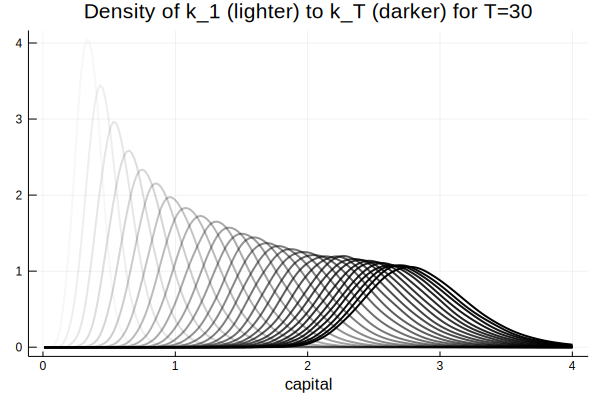

In [3]:
using Distributions, StatsPlots, Plots, QuantEcon, Random
Random.seed!(42) # Para resulados determinísticos.

s = 0.2
δ = 0.1
a_σ = 0.4                    # A = exp(B) onde B ~ N(0, a_σ)
α = 0.4                      # definimos f(k) = k**α
ψ_0 = Beta(5.0, 5.0)         # distribuição inicial
ϕ = LogNormal(0.0, a_σ)

function p(x, y)
    # Núcleo estocástico para o modelo de crescimento com produção de Cobb-Douglas..
    # Ambos x e y devem ser estritamente positivos.

    d = s * x.^α

    pdf_arg = clamp.((y .- (1-δ) .* x) ./ d, eps(), Inf)
    return pdf.(ϕ, pdf_arg) ./ d
end

n = 10000  # Número de observações em cada data t 
T = 30     # Densidade computacional de k_t em 1, ..., T + 1

# Gera a matriz st-ésima coluna é n observações de k_t 
k = zeros(n, T)
A = rand!(ϕ, zeros(n, T))

# Extra a primeira coluna da distribuição inicial
k[:, 1] = rand(ψ_0, n) ./ 2  # divida por 2 para corresponder à escala = 0,5 na versão py
for t in 1:T-1
    k[:, t+1] = s*A[:, t] .* k[:, t].^α + (1-δ) .* k[:, t]
end

# Gere instâncias T de LAE usando esses dados, um para cada data t 
laes = [LAE(p, k[:, t]) for t in T:-1:1]

# Plot
ygrid = range(0.01, 4, length = 200)
laes_plot = []
colors = []
for i in 1:T
    ψ = laes[i]
    push!(laes_plot, lae_est(ψ , ygrid))
    push!(colors,  RGBA(0, 0, 0, 1 - (i - 1)/T))
end
plot(ygrid, laes_plot, color = reshape(colors, 1, length(colors)), lw = 2,
     xlabel = "capital", legend = :none)
t = "Density of k_1 (lighter) to k_T (darker) for T=$T"
plot!(title = t)

A figura mostrará parte da sequência de densidade $ \{\psi_t\} $, com cada densidade calculada pelo estimador antecipador.

Observe que a sequência de densidades mostrada na figura parece estar convergindo - mais sobre isso em apenas um momento.

Outro comentário rápido é que cada uma dessas distribuições pode ser interpretada como uma distribuição transversal (lembre-se [dessa discursão](https://julia.quantecon.org/finite_markov.html#mc-eg1-1)).

## Além das Densidades

Até agora, nos concentramos exclusivamente em cadeias de Markov de estado contínuo, onde todas as distribuições condicionais $ p(x, \cdot) $ são densidades.

Como discutido acima, nem todas as distribuições podem ser representadas como densidades.

Se a distribuição condicional de $ X_{t+1} $ dado $ X_t = x $
**não pode** ser representado como uma densidade para alguns $ x \in S $, então precisamos de uma teoria ligeiramente diferente.

A opção final é mudar de densidades para [medidas de probabilidades](https://en.wikipedia.org/wiki/Probability_measure), mas nem todos os leitores estarão familiarizados com a teoria da medida.

No entanto, podemos construir uma teoria bastante geral usando funções de distribuição.

### Exemplos e Definições

Para ilustrar as questões, lembre-se de que Hopenhayn e Rogerson  [[HR93]](https://julia.quantecon.org/../zreferences.html#hopenhaynrogerson1993) estudam um modelo de dinâmica da empresa em que a produtividade individual da empresa segue o processo exógeno

$$
X_{t+1} = a + \rho X_t + \xi_{t+1},
\quad \text{onde} \quad
\{ \xi_t \} \stackrel {\textrm{ IID }} {\sim} N(0, \sigma^2)
$$

Como é, isso se encaixa no caso de densidade que tratamos acima.

No entanto, os autores queriam que esse processo levasse valores em $ [0, 1] $, então eles adicionaram limites nos pontos finais 0 e 1.

Uma forma de escrever isso é

$$
X_{t+1} = h(a + \rho X_t + \xi_{t+1})
\quad \text{onde} \quad
h(x) := x \, \mathbf 1\{0 \leq x \leq 1\} + \mathbf 1 \{ x > 1\}
$$

Se você pensar sobre isso, você vai ver que para qualquer dado  $ x \in [0, 1] $,
a distribuição condicional de $ X_{t+1} $ dado $ X_t = x $
coloca a massa de probabilidade positiva em 0 e 1

Portanto, não pode ser representado como uma densidade.

O que podemos fazer é usar funções de distribuição cumulativa (fdp's).

Para esse fim, defina

$$
G(x, y) := \mathbb P \{ h(a + \rho x + \xi_{t+1}) \leq y \}
\qquad (0 \leq x, y \leq 1)
$$

Esta família de fdp's  $ G(x, \cdot) $ desempenha um papel análogo ao núcleo estocástico no caso de densidade.

A dinâmica de distribuição em [(9)](#equation-statd-fdd) e então substituída por


<a id='equation-statd-fddc'></a>
$$
F_{t+1}(y) = \int G(x,y) F_t(dx) \tag{14}
$$

Aqui $ F_t $ e $ F_{t+1} $ são fpd's representando a distribuição do estado atual e do próximo período.

A intuição por trás de [(14)](#equation-statd-fddc) é essencialmente a mesma para [(9)](#equation-statd-fdd).

### Computação

Se você deseja calcular esses cdfs, não pode usar o estimador antecipado como antes.

De fato, você não deve usar nenhum estimador de densidade, pois os objetos que você está estimando / computando não são densidades.

Uma boa opção é a simulação como antes, combinada com a [função de distribuição empírica](https://en.wikipedia.org/wiki/Empirical_distribution_function).

## Estabilidade

Na nossa [aula](https://julia.quantecon.org/finite_markov.html) sobre cadeias de Markov finitas estudamos também estacionariedade, estabilidade e ergodicidade.

Aqui abordaremos os mesmos tópicos para o caso contínuo.

No entanto, trataremos apenas o caso da densidade (como [nessa seção](#statd-density-case)), onde o núcleo estocástico é uma família de densidades.

O caso geral é relativamente semelhante - as referências são dadas abaixo.

### Resultados Teóricos

Análogo ao [caso finito](https://julia.quantecon.org/finite_markov.html#mc-stat-dd), dado um núcleo estocástico $ p $ e operador Markov correspondente, conforme definido em  [(10)](#equation-def-dmo), uma densidade $ \psi^* $ em $ S $ é chamada de
*estacionária* para $ P $ se é um ponto fixo do operador $ P $.

Em outras palavras,


<a id='equation-statd-dsd'></a>
$$
\psi^*(y) = \int p(x,y) \psi^*(x) \, dx,
\qquad \forall y \in S \tag{15}
$$

Como no caso finito, se $ \psi^* $ é estacionário para $ P $, e a distribuição de $ X_0 $ é $ \psi^* $, então, em vista de
[(11)](#equation-statd-p), $ X_t $ terá essa mesma distribuição para todo $ t $.

Portanto $ \psi^* $ é o equivalente estocástico de um estado estacionário.

No caso finito, aprendemos que pelo menos uma distribuição estacionária existe, embora possa haver muitas.

Quando o espaço de estados é infinito, a situação é mais complicada.

Até a existência pode falhar com muita facilidade.

Por exemplo, o modelo de passeio aleatório não possui densidade estacionária (consulte, por exemplo [EDTC](http://johnstachurski.net/edtc.html), p. 210).

No entanto, existem condições bem conhecidas sob as quais uma densidade estacionária $ \psi^* $ existe.

Com condições adicionais, que também pode obter uma densidade estacionária original ($ \psi \in \mathscr D \text{ and } \psi = \psi P \implies \psi = \psi^* $),  e também convergência global no sentido de que


<a id='equation-statd-dca'></a>
$$
\forall \, \psi \in \mathscr D, \quad \psi P^t \to \psi^*
    \quad \text{as} \quad t \to \infty \tag{16}
$$

Essa combinação de existência, singularidade e convergência global no sentido de [(16)](#equation-statd-dca) é frequentemente referida como *estabilidade global*.

Sob condições muito semelhantes, obtemos *ergodicidade*, que significa que


<a id='equation-statd-lln'></a>
$$
\frac{1}{n} \sum_{t = 1}^n h(X_t)  \to \int h(x) \psi^*(x) dx
    \quad \text{as } n \to \infty \tag{17}
$$

para qualquer função ([mensurável](https://en.wikipedia.org/wiki/Measurable_function)) $ h \colon S \to \mathbb R $   de modo que o lado direito seja finito.

Observe que a convergência em [(17)](#equation-statd-lln) não depende da distribuição (ou valor) de $ X_0 $.

Isso é realmente muito importante para simulação - significa que podemos aprender sobre $ \psi^* $ (ou seja, aproxime o lado direito de [(17)](#equation-statd-lln) pelo lado esquerdo) sem exigir nenhum conhecimento especial sobre o que fazer com $ X_0 $.

Então, quais são essas condições necessárias para obter estabilidade e ergodicidade global?

Em essência, deve ser o caso que

1. A massa de probabilidade não deriva para as "arestas" do espaço de estados
1. Obtém-se “mistura” suficiente

Para um desses conjuntos de condições, consulte o teorema 8.2.14 do [EDTC](http://johnstachurski.net/edtc.html).

além do mais:

- [[SLP89]](https://julia.quantecon.org/../zreferences.html#stokeylucas1989)  contém um tratamento clássico (mas um pouco desatualizado) desses tópicos.
- A partir da literatura matemática, [[LM94]](https://julia.quantecon.org/../zreferences.html#lasotamackey1994)  e [[MT09]](https://julia.quantecon.org/../zreferences.html#meyntweedie2009) oferecem excelentes tratamentos em profundidade.  
- A seção 8.1.2 of [EDTC](http://johnstachurski.net/edtc.html) fornece intuição detalhada e a seção 8.3 fornece referências adicionais.
- [EDTC](http://johnstachurski.net/edtc.html), seção 11.3.4
  fornece um tratamento específico para o modelo de crescimento que consideramos nesta palestra. 

### Um Exemplo de Estabilidade

Como afirmado acima, o [modelo de crescimento tratado aqui](#solow-swan) é estável sob condições suaves nas primitivas.

- Veja [EDTC](http://johnstachurski.net/edtc.html), seção 11.3.4 para mais detalhes.  


Podemos ver essa estabilidade em ação - em particular a convergência em [(16)](#equation-statd-dca) — simulando o caminho das densidades a partir de várias condições iniciais.

Aqui está uma figura


<a id='statd-egs'></a>
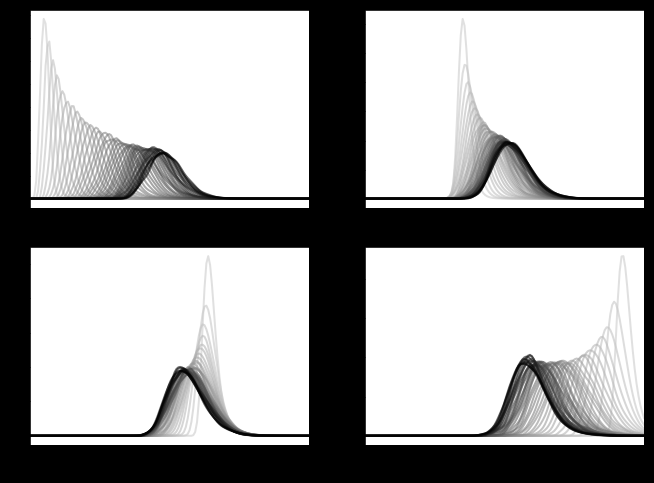

  
Todas as sequências estão convergindo para o mesmo limite, independentemente de sua condição inicial.

Os detalhes sobre as condições iniciais e assim por diante são fornecidos [nesse exercício](#statd-ex2), onde você é solicitado a replicar a figura.

### Computando Densidades Estacionárias

Na figura precedente, cada sequência de densidades converge para a densidade estacionária original $ \psi^* $.

Mesmo a partir desta figura podemos ter uma boa idéia do que $ \psi^* $ parece, e onde sua massa está localizada.

No entanto, existe uma maneira muito mais direta de estimar a densidade estacionária e envolve apenas uma ligeira modificação do estimador antecipado.

Digamos que temos um modelo da forma [(3)](#equation-statd-srs) que é estável e ergódico.

Seja $ p $ correspondente ao núcleo estocástico, como dado em [(7)](#equation-statd-srssk).

Para aproximar a densidade estacionária $ \psi^* $, podemos simplesmente gerar uma longa serie temporal $ X_0, X_1, \ldots, X_n $ e estimar $ \psi^* $ através de


<a id='equation-statd-lae2'></a>
$$
\psi_n^*(y) = \frac{1}{n} \sum_{t=1}^n p(X_t, y) \tag{18}
$$

É essencialmente o mesmo que o estimador de antecipação [(13)](#equation-statd-lae1),
exceto que agora as observações que geramos são uma única série temporal, e não uma seção transversal.

A justificativa para [(18)](#equation-statd-lae2) é que, que a probabilidade um como $ n \to \infty $,

$$
\frac{1}{n} \sum_{t=1}^n p(X_t, y)
\to
\int p(x, y) \psi^*(x) \, dx
= \psi^*(y)
$$

onde a convergência é para [(17)](#equation-statd-lln) e a igualdade à direita é de
[(15)](#equation-statd-dsd).

O lado direito é exatamente o que queremos calcular.

Além desse resultado assintótico, verifica-se que a taxa de convergência para o estimador de antecipação é muito boa.

O primeiro exercício ajuda a ilustrar esse ponto.

## Exercícios

<a id='statd-ex1'></a>


Considere o modelo autoregressivo de limite simples


<a id='equation-statd-tar'></a>
$$
X_{t+1} = \theta |X_t| + (1- \theta^2)^{1/2} \xi_{t+1}
\qquad \text{onde} \quad
\{ \xi_t \} \stackrel {\textrm{ IID }} {\sim} N(0, 1) \tag{19}
$$

Este é um daqueles raros modelos estocásticos não lineares em que uma expressão analítica para a densidade estacionária está disponível.

Em particular, desde que  $ |\theta| < 1 $, existe uma única densidade estacionária $ \psi^* $ dada por


<a id='equation-statd-tar-ts'></a>
$$
\psi^*(y) = 2 \, \phi(y) \, \Phi
\left[
    \frac{\theta y}{(1 - \theta^2)^{1/2}}
\right] \tag{20}
$$

Aqui $ \phi $ é a densidade normal padrão e $ \Phi $ é a fdp padrão normal

Como exercício, compute o estimador de aproximação de $ \psi^* $, como definido em [(18)](#equation-statd-lae2), e compare o com $ \psi^* $  em [(20)](#equation-statd-tar-ts) para ver se eles são de fato próximos para um grande $ n $.

Ao fazer isso, defina $ \theta = 0.8 $ e $ n = 500 $.

A próxima figura mostra o resultado de tal computação

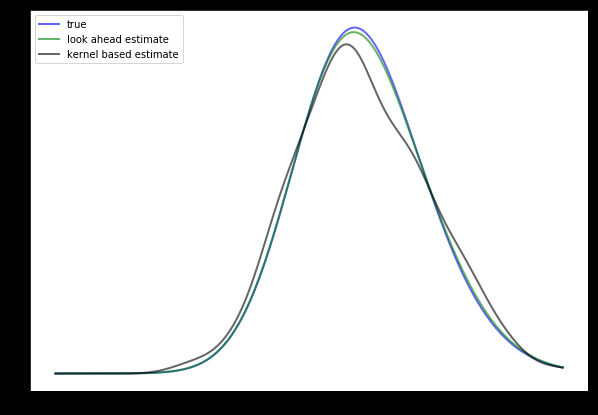

  
A densidade adicional (linha preta) é uma  [é uma estimativa não-paramétrica da densidade de kernel](https://en.wikipedia.org/wiki/Kernel_density_estimation), adicionada à solução para ilustração.

(Você pode tentar replicá-lo antes de procurar a solução, se desejar)

Como você pode ver, o estimador de antecipação é um ajuste muito mais rigoroso do que o estimador de densidade do kernel.

Se você repetir a simulação, verá que esse é sempre o caso.


<a id='statd-ex2'></a>

### Exercício 2

Replique a figura sobre convergência global [mostrada acima](#statd-egs).

As densidades provêm do modelo de crescimento estocástico tratado [no início da aula](#solow-swan).

Começe com o código encontrado [stochasticgrowth.py](https://github.com/QuantEcon/QuantEcon.lectures.code/blob/master/stationary_densities/stochasticgrowth.jl).

Use os mesmos parâmetros.

Para as quatro distribuições iniciais, use a distribuição beta e altere os sorteios aleatórios, como mostrado abaixo

> 

```text
ψ_0 = Beta(5.0, 5.0)  # Initial distribution
n = 1000
# .... more setup

for i in 1:4
    # .... some code
    rand_draws = (rand(ψ_0, n) .+ 2.5i) ./ 2
```




<a id='statd-ex3'></a>

### Exercício 3

Uma maneira comum de comparar visualmente distribuições é com [boxplots](https://en.wikipedia.org/wiki/Box_plot).

Para ilustrar,  vamos gerar três conjuntos de dados artificiais e compará-los com um boxplot.

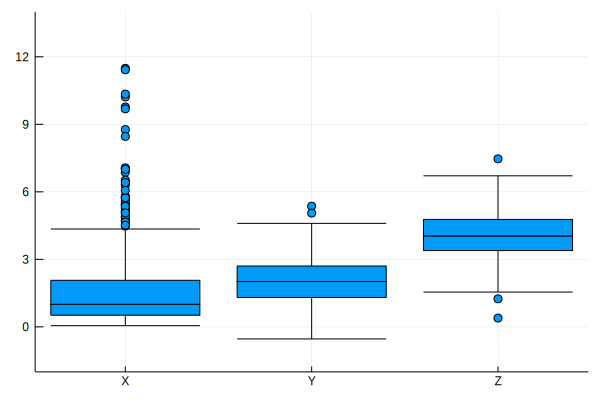

In [4]:
n = 500
x = randn(n)        # N(0, 1)
x = exp.(x)         # Map x to lognormal
y = randn(n) .+ 2.0  # N(2, 1)
z = randn(n) .+ 4.0  # N(4, 1)
data = vcat(x, y, z)
l = ["X" "Y" "Z"]
xlabels = reshape(repeat(l, n), 3n, 1)

boxplot(xlabels, data, label = "", ylims = (-2, 14))

Os três conjuntos de dados são:

$$
\{ X_1, \ldots, X_n \} \sim LN(0, 1), \;\;
\{ Y_1, \ldots, Y_n \} \sim N(2, 1), \;\;
\text{ e } \;
\{ Z_1, \ldots, Z_n \} \sim N(4, 1), \;
$$

A figura é a seguinte.

Cada conjunto de dados é representado por uma caixa, onde a parte superior e inferior da caixa são o terceiro e o primeiro quartil dos dados, e a linha vermelha no centro é a mediana.

As caixas dão alguma indicação sobre

- a localização da massa de probabilidade para cada amostra
- se a distribuição está inclinada para a direita (como é a distribuição normal do log), etc


Agora vamos usar essas idéias em uma simulação.

Considere o modelo autoregressivo de limite em [(19)](#equation-statd-tar).

Sabemos que a distribuição de  $ X_t $ convergirá para [(20)](#equation-statd-tar-ts) sempre que $ |\theta| < 1 $.

Vamos observar essa convergência de diferentes condições iniciais usando boxplots.

Em particular, o exercício é gerar J figuras boxplot, um para cada condição incial $ X_0 $ em:

```julia
initial_conditions = range(8, 0, length = J)
```


Para cada $ X_0 $ nesse conjunto,

1. Gere $ k $ séries temporais de tamanho $ n $, cada uma iniciando em $ X_0 $ e obedecendo a [(19)](#equation-statd-tar).  
1. Crie um boxplot representando $ n $ distribuições, onde a $ t $-ésima distribuição mostra $ k $ observações de $ X_t $.  


Use $ \theta = 0.9, n = 20, k = 5000, J = 8 $.

## Soluções

In [5]:
using KernelDensity

### Exercício 1

O estimador de antecipação de uma densidade estacionária TAR, onde o modelo TAR é

$$
X_{t+1} = \theta |X_t| + (1 - \theta^2)^{1/2} \xi_{t+1}
$$

e $ \xi_t \sim N(0,1) $. tente rodar em n = 10, 100, 1000, 10000
para ter uma idéia da velocidade de convergência.

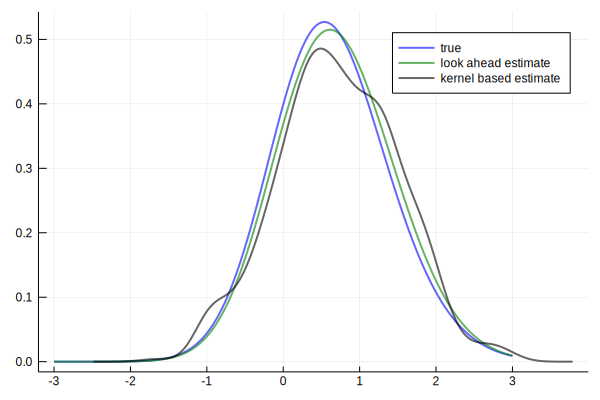

In [6]:
ϕ = Normal()
n = 500
θ = 0.8
d = sqrt(1.0 - θ^2)
δ = θ / d

# verdadeira densidade do modelo TAR
ψ_star(y) = 2 .* pdf.(ϕ, y) .* cdf.(ϕ, δ * y)

# Núcleo estocástico para o modelo TAR.
p_TAR(x, y) = pdf.(ϕ, (y .- θ .* abs.(x)) ./ d) ./ d

Z = rand(ϕ, n)
X = zeros(n)
for t in 1:n-1
    X[t+1] = θ * abs(X[t]) + d * Z[t]
end

ψ_est(a) = lae_est(LAE(p_TAR, X), a)
k_est = kde(X)

ys = range(-3, 3, length = 200)
plot(ys, ψ_star(ys), color=:blue, lw = 2, alpha = 0.6, label = "true")
plot!(ys, ψ_est(ys), color=:green, lw = 2, alpha = 0.6, label = "look ahead estimate")
plot!(k_est.x, k_est.density, color = :black, lw = 2, alpha = 0.6,
      label = "kernel based estimate")

### Exercício 2

Aqui está um programa que faz o trabalho.

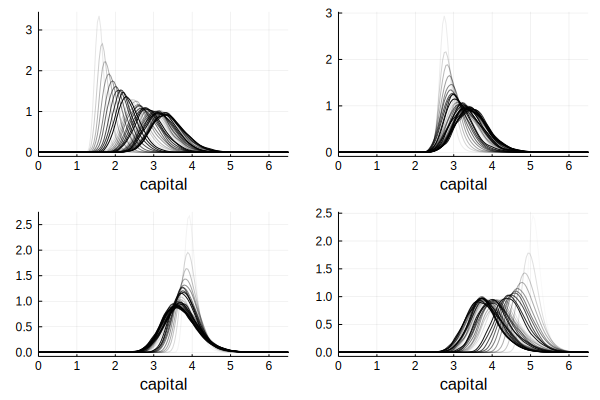

In [7]:
s = 0.2
δ = 0.1
a_σ = 0.4  # A = exp(B) onde B ~ N(0, a_σ)
α = 0.4    # Definimos f(k) = k**α
ψ_0 = Beta(5.0, 5.0)  # distribuição inicial
ϕ = LogNormal(0.0, a_σ)

function p_growth(x, y)
    # Núcleo estocástico para um modelo de crescimento com função de produção Cobb-Douglas.
    # Ambos x e y devem ser estritamente positivos.

        d = s * x.^α

    pdf_arg = clamp.((y .- (1-δ) .* x) ./ d, eps(), Inf)
    return pdf.(ϕ, pdf_arg) ./ d
end

n = 1000  # Número de observações em cada momento t 
T = 40    # densidade computacional de k_t at 1,...,T+1

xmax = 6.5
ygrid = range(0.01, xmax, length = 150)
laes_plot = zeros(length(ygrid), 4T)
colors = []
for i in 1:4
    k = zeros(n, T)
    A = rand!(ϕ, zeros(n, T))

    # Extrai a primeira coluna da condição inicial
    # escala de correspondência = 0.5 e loc = 2i na versão do Julia
    k[:, 1] = (rand(ψ_0, n) .+ 2.5i) ./ 2
    for t in 1:T-1
        k[:, t+1] = s * A[:, t] .* k[:, t].^α + (1 - δ) .* k[:, t]
    end

    # gera T instâncias de LAE usando esses dados, para cada momento t
    laes = [LAE(p_growth, k[:, t]) for t in T:-1:1]
    ind = i
    for j in 1:T
        ψ = laes[j]
        laes_plot[:, ind] = lae_est(ψ, ygrid)
        ind = ind + 4
        push!(colors,  RGBA(0, 0, 0, 1 - (j - 1) / T))
    end
end

#cores = reshape(reshape(colors, T, 4)', 4*T, 1)
colors = reshape(colors, 1, length(colors))
plot(ygrid, laes_plot, layout = (2,2), color = colors,
     legend = :none, xlabel = "capital", xlims = (0, xmax))

### Exercício 3

Aqui está uma solução possível.

Observe como usamos o código vetorizado para simular $ k $ séries temporais para um boxplot de uma só vez.

In [8]:
n = 20
k = 5000
J = 6

θ = 0.9
d = sqrt(1 - θ^2)
δ = θ / d

initial_conditions = range(8, 0, length = J)

Z = randn(k, n, J)
titles = []
data = []
x_labels = []
for j in 1:J
    title = "time series from t = $(initial_conditions[j])"
    push!(titles, title)

    X = zeros(k, n)
    X[:, 1] .= initial_conditions[j]
    labels = []
    labels = vcat(labels, ones(k, 1))
    for t in 2:n
        X[:, t] = θ .* abs.(X[:, t-1]) .+ d .* Z[:, t, j]
        labels = vcat(labels, t*ones(k, 1))
    end
    X = reshape(X, n*k, 1)
    push!(data, X)
    push!(x_labels, labels)
end

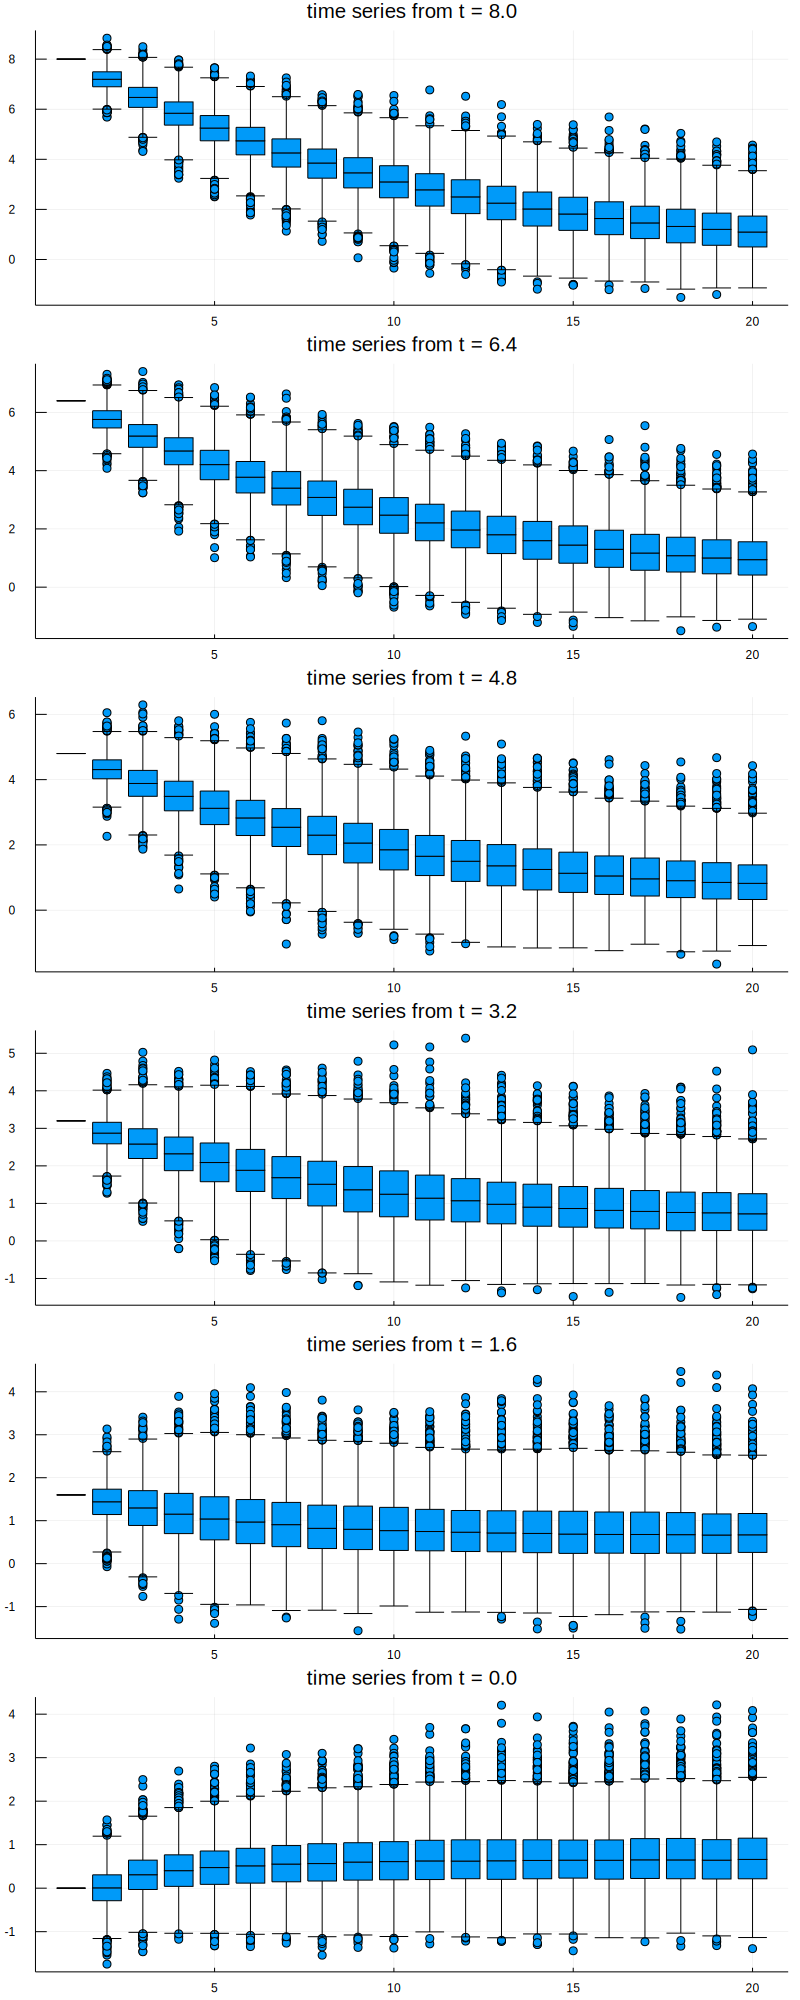

In [9]:
plots = []
for i in 1:J
    push!(plots, boxplot(vec(x_labels[i]), vec(data[i]), title = titles[i]))
end
plot(plots..., layout = (J, 1), legend = :none, size = (800, 2000))

## Apêndice

<a id='statd-appendix'></a>
Aqui está uma prova de [(6)](#equation-statd-dv).

Seja $ F_U $ e $ F_V $ a distribuição cumulativa de $ U $ e $ V $ respectivamente.

Pelas definições de $ V $, temos $ F_V(v) = \mathbb P \{ a + b U \leq v \} = \mathbb P \{ U \leq (v - a) / b \} $.

Em outras palavras, $ F_V(v) = F_U ( (v - a)/b ) $.

Diferenciando com respeito a variável produção $ v $ [(6)](#equation-statd-dv).